# **ARIMA model**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load the dataset
file_path = '/content/drive/MyDrive/Sbsolution/SalesData.xlsx'
data = pd.read_excel(file_path)

# Convert 'Invoiced Date' to datetime and set it as the index
data['Invoiced Date'] = pd.to_datetime(data['Invoiced Date'])
data.set_index('Invoiced Date', inplace=True)

# Group data by 'Item Category' (to focus on each Item Category) and 'Invoiced Date', then sum up sales
data = data.groupby(['Item Category', 'Invoiced Date']).agg({
    'Quantity': 'sum',
    'Sales Amount': 'sum',
    'Gross Profit': 'sum',
    'Item No.': 'first',
    'Order Type': 'first',
    'Salesperson Code': 'first'
}).reset_index()


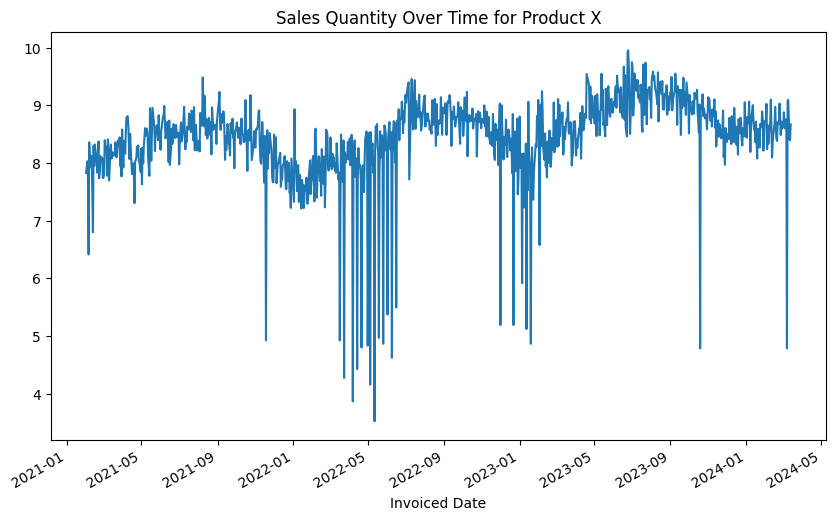

In [ ]:

product_data = data[data['Item Category'] == 'Beverages']

# Set 'Invoiced Date' as index to create a time series
product_data = product_data.set_index('Invoiced Date')
product_data_sorted = product_data.sort_index(ascending=True)
product_data_skipped = product_data_sorted.iloc[:-30]
# Use 'Quantity' as the target for forecasting
product_sales = np.log(product_data_skipped['Quantity'])

# Plot the time series
product_sales.plot(title='Sales Quantity Over Time for Product X', figsize=(10, 6))
plt.show()


In [ ]:
product_data_sorted

,Item Category,Quantity,Sales Amount,Gross Profit,Item No.,Order Type,Salesperson Code
Invoiced Date,,,,,,,
2021-02-01,Beverages,2509,525.610,20.224,20307,RETAIL,1002
2021-02-02,Beverages,2766,595.542,22.160,20306,RETAIL,1002
2021-02-03,Beverages,3070,672.084,21.140,20307,RETAIL,1002
2021-02-04,Beverages,2240,469.642,18.447,20041,RETAIL,1002
2021-02-05,Beverages,611,204.070,5.255,20069,RETAIL,1002
...,...,...,...,...,...,...,...
2024-04-15,Beverages,5096,1094.679,40.747,22759,RETAIL,1002
2024-04-16,Beverages,4978,904.837,32.226,20464,RETAIL,1002
2024-04-17,Beverages,8903,2198.083,65.783,22569,RETAIL,1002


In [ ]:
product_sales

,Quantity
Invoiced Date,
2021-02-01,7.827640
2021-02-02,7.925158
2021-02-03,8.029433
2021-02-04,7.714231
2021-02-05,6.415097
...,...
2024-03-09,9.093357
2024-03-10,8.782630
2024-03-11,8.410498


In [ ]:
# Define a function to check stationarity using ADF test
def adf_test(time_series):
    result = adfuller(time_series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

# Perform ADF test on original sales data
adf_test(product_sales)


ADF Statistic: -2.168811699160978
p-value: 0.21775906152489904
The time series is not stationary.


In [ ]:
# Differencing the data
product_sales_diff = product_sales.diff().dropna()

# Check for stationarity again
adf_test(product_sales_diff)

# Keep differencing until the data is stationary
d = 1  # Initial differencing

while adfuller(product_sales_diff)[1] > 0.05:
    product_sales_diff = product_sales_diff.diff().dropna()
    d += 1

print(f'Differencing order (d): {d}')


ADF Statistic: -11.455064063220377
p-value: 5.733304670523557e-21
The time series is stationary.
Differencing order (d): 1


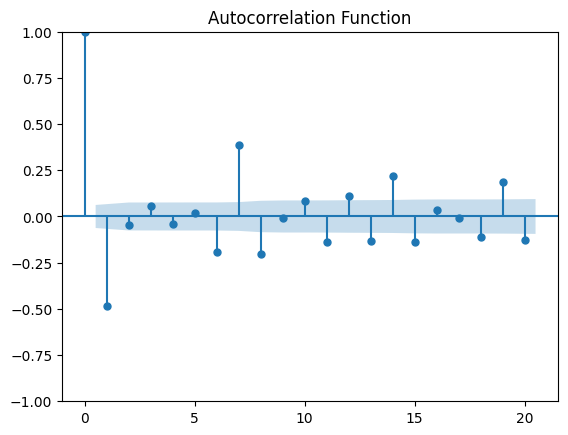

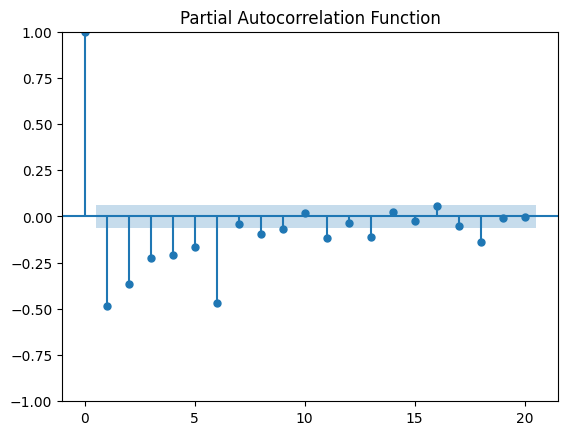

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(product_sales_diff, lags=20)
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plot_pacf(product_sales_diff, lags=20)
plt.title('Partial Autocorrelation Function')
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Example values for p and q; replace these with identified values from ACF/PACF
p = 13  # Replace with identified p
q = 1  # Replace with identified q

# Define the ARIMA model
model = ARIMA(product_sales, order=(p, d, q))

# Fit the model
arima_result = model.fit()

# Summary of the model
print(arima_result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  988
Model:                ARIMA(13, 1, 1)   Log Likelihood                -808.693
Date:                Fri, 04 Oct 2024   AIC                           1647.387
Time:                        11:21:50   BIC                           1720.807
Sample:                             0   HQIC                          1675.309
                                - 988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1069      0.116     -0.921      0.357      -0.335       0.121
ar.L2         -0.1662      0.103     -1.617      0.106      -0.368       0.035
ar.L3         -0.0871      0.108     -0.804      0.4

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


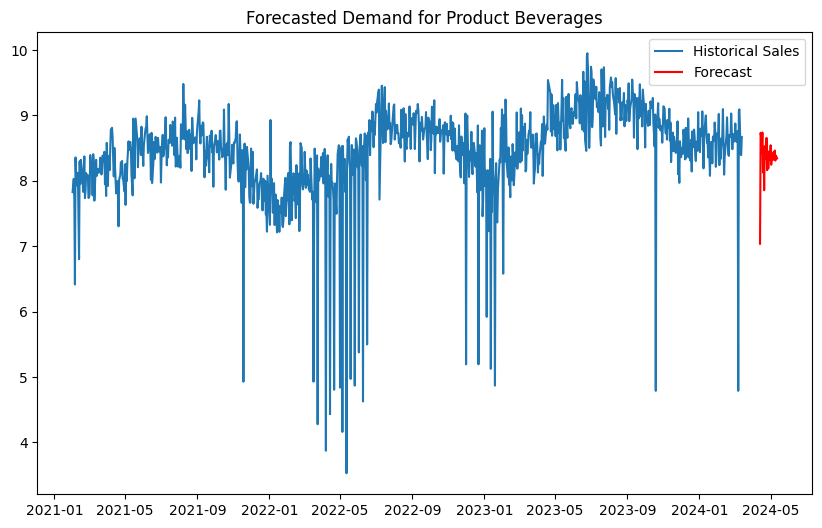

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `product_sales` is your DataFrame with a DateTime index
# and `arima_result` is your fitted ARIMA model

# Forecast the next 10 time periods
forecast = arima_result.forecast(steps=30)

# Create a date range for the forecasted values
forecast_index = pd.date_range(start=product_sales.index[-1] + pd.DateOffset(months=1), periods=30, freq='D')

# Plot the forecasted demand
plt.figure(figsize=(10, 6))
plt.plot(product_sales.index, product_sales, label='Historical Sales')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Forecasted Demand for Product Beverages')
plt.legend()
plt.show()


In [ ]:
df_forecast = pd.DataFrame(data=forecast)
df_forecast['predicted_mean']
last_30_quantity = product_data_sorted['Quantity'].tail(30)
log_last_30_sales = np.log(last_30_quantity)
df_forecast['actual'] = log_last_30_sales.values

# Calculate the Mean Squared Error for each row
mse_values = (df_forecast['predicted_mean'] - df_forecast['actual']) ** 2

# Add MSE as a new column named 'MSE'
df_forecast['MSE'] = mse_values


In [ ]:
df_forecast

,predicted_mean,actual,MSE
988,7.037631,8.412721,1.890874
989,8.734593,8.497603,0.056165
990,8.657191,8.343316,0.098518
991,8.436926,8.205492,0.053562
992,8.738711,7.952263,0.618500
993,8.127432,8.333030,0.042271
994,8.518747,8.409162,0.012009
995,7.857210,8.770750,0.834555
996,8.530772,8.337588,0.037320
997,8.473143,8.946505,0.224072


In [ ]:
# Calculate MAPE
df_forecast['MAPE'] = (np.abs((df_forecast['actual'] - df_forecast['predicted_mean']) / df_forecast['actual'])) * 100


In [ ]:
# Reverse the log transformation for 'predicted_mean' and 'actual'
df_forecast['predicted_mean_actual_values'] = np.exp(df_forecast['predicted_mean'])
df_forecast['actual_actual_values'] = np.exp(df_forecast['actual'])


In [ ]:
df_forecast

,predicted_mean,actual,MSE,MAPE,predicted_mean_actual_values,actual_actual_values
988,7.037631,8.412721,1.890874,16.345370,1138.686582,4504.0
989,8.734593,8.497603,0.056165,2.788912,6214.205944,4903.0
990,8.657191,8.343316,0.098518,3.761994,5751.355992,4202.0
991,8.436926,8.205492,0.053562,2.820487,4614.350593,3661.0
992,8.738711,7.952263,0.618500,9.889606,6239.846180,2842.0
993,8.127432,8.333030,0.042271,2.467269,3386.091873,4159.0
994,8.518747,8.409162,0.012009,1.303157,5007.775083,4488.0
995,7.857210,8.770750,0.834555,10.415757,2584.299026,6443.0
996,8.530772,8.337588,0.037320,2.317022,5068.355326,4178.0
997,8.473143,8.946505,0.224072,5.291031,4784.528140,7681.0


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Example: Forecasted demand for the next 30 days (replace with your actual data)
forecasted_demand = np.array([df_forecast['predicted_mean_actual_values']])

# Calculate the standard deviation of the forecasted demand
sigma_d = np.std(forecasted_demand)

# Average daily demand
avg_demand = np.mean(forecasted_demand)

service_levels = [0.80, 0.85, 0.90, 0.95, 0.99]
for z in service_levels:
  print(f'Safety Stock (z={round(z, 2)})')
  # Z-score for desired service level (e.g., 95% service level corresponds to Z = 1.65)
  Z = norm.ppf(z)  # You can change this to match your desired service level

  # Lead times to consider (in days)
  lead_times = [1, 2, 3, 4, 5]

  # Calculate safety stock for each lead time
  safety_stock = {}
  for L in lead_times:
      ss = Z * sigma_d * np.sqrt(L)  # Formula: Z * σ_d * sqrt(L)
      safety_stock[L] = ss

  # Output the safety stock for each lead time
  for L, ss in safety_stock.items():
      print(f"Safety Stock for lead time {L} days: {ss:.2f} units")

Safety Stock (z=0.8)
Safety Stock for lead time 1 days: 833.90 units
Safety Stock for lead time 2 days: 1179.32 units
Safety Stock for lead time 3 days: 1444.36 units
Safety Stock for lead time 4 days: 1667.81 units
Safety Stock for lead time 5 days: 1864.67 units
Safety Stock (z=0.85)
Safety Stock for lead time 1 days: 1026.93 units
Safety Stock for lead time 2 days: 1452.30 units
Safety Stock for lead time 3 days: 1778.70 units
Safety Stock for lead time 4 days: 2053.86 units
Safety Stock for lead time 5 days: 2296.29 units
Safety Stock (z=0.9)
Safety Stock for lead time 1 days: 1269.80 units
Safety Stock for lead time 2 days: 1795.77 units
Safety Stock for lead time 3 days: 2199.36 units
Safety Stock for lead time 4 days: 2539.60 units
Safety Stock for lead time 5 days: 2839.36 units
Safety Stock (z=0.95)
Safety Stock for lead time 1 days: 1629.77 units
Safety Stock for lead time 2 days: 2304.85 units
Safety Stock for lead time 3 days: 2822.85 units
Safety Stock for lead time 4 days